<a href="https://colab.research.google.com/github/esteban-miller/4.Analisis-exploratorio/blob/main/analisis-bivariable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import scipy.stats as st
import kagglehub
import os
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, spearmanr, kruskal, mannwhitneyu

In [ ]:
import os
print(os.listdir("/content"))

['.config', 'sample_data']


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving drug200.csv to drug200.csv


In [ ]:
import pandas as pd

file_path = "/content/drug200.csv"
df = pd.read_csv(file_path)

df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


Variables numéricas (continuas):
- Age (Edad): Variable continua
- Na_to_K: Variable continua, mide la proporción entre sodio y potasio en el cuerpo.

Variables categóricas:
- Sex (Sexo): Variable categórica binaria con clases
- BP (Presión arterial): Variable categórica ordinal con clases
- Cholesterol (Colesterol): Variable categórica ordinal con clases
- Drug (Tipo de medicamento, variable objetivo): Variable categórica con clases

In [ ]:
X = df.drop(columns=["Drug"])
y = df[["Drug"]]

In [ ]:
X.head(), y.head()


(   Age Sex      BP Cholesterol  Na_to_K
 0   23   F    HIGH        HIGH   25.355
 1   47   M     LOW        HIGH   13.093
 2   47   M     LOW        HIGH   10.114
 3   28   F  NORMAL        HIGH    7.798
 4   61   F     LOW        HIGH   18.043,
     Drug
 0  DrugY
 1  drugC
 2  drugC
 3  drugX
 4  DrugY)

In [ ]:
# Normalidad de las variables continuas
for i in X.select_dtypes(include="number").columns:
    statistic, p_value = st.shapiro(X[i])
    print(f"Columna: {i}")
    print(f"Estadística: {statistic}")
    print(f"Valor p: {p_value}")
    alpha = 0.05
    if p_value > alpha:
        print("Los datos siguen una distribución normal (no se rechaza la hipótesis nula)")
    else:
        print("Los datos no siguen una distribución normal (se rechaza la hipótesis nula)")
    print("\n")

Columna: Age
Estadística: 0.9639394070306962
Valor p: 5.408407721090134e-05
Los datos no siguen una distribución normal (se rechaza la hipótesis nula)


Columna: Na_to_K
Estadística: 0.9018589057639175
Valor p: 3.305569554888298e-10
Los datos no siguen una distribución normal (se rechaza la hipótesis nula)




Ambas variables, Age y Na_to_K, tienen valores bajos (p < 0.05), lo que indica que no siguen una distribución normal.


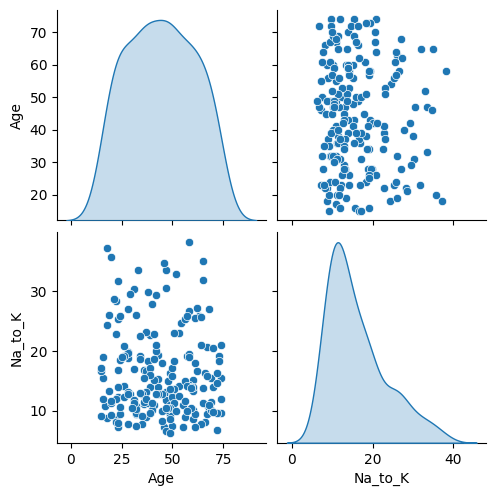

In [ ]:
# Pairplot de las variables continuas
sns.pairplot(X, diag_kind="kde")
plt.show()


Se observan relaciones no lineales entre las variables numéricas.
La variable Na_to_K parece tener una distribución asimétrica y valores extremos.

In [ ]:
# Detección de outliers con IQR
def outliers_iqr(df, colname: str) -> pd.DataFrame:
    q1 = df[colname].quantile(0.25)
    q3 = df[colname].quantile(0.75)
    iqr = q3 - q1
    outliers = ((df[colname] < q1 - 1.5 * iqr) | (df[colname] > q3 + 1.5 * iqr))
    return df[outliers]

for i in X.select_dtypes(include="number").columns:
    outliers = outliers_iqr(X, i)
    print(f'La columna {i} tiene {len(outliers)} outliers')

La columna Age tiene 0 outliers
La columna Na_to_K tiene 8 outliers


Se han detectado valores atípicos en las variables numéricas, especialmente en Na_to_K.
Esto puede indicar la presencia de sujetos con niveles inusuales de sodio/potasio, lo cual podría afectar la clasificación de medicamentos.

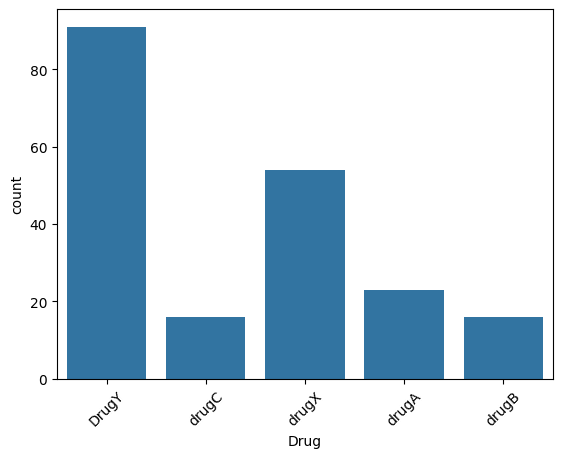

In [ ]:
# Distribución de la variable dependiente
sns.countplot(x=y["Drug"])
plt.xticks(rotation=45)
plt.show()

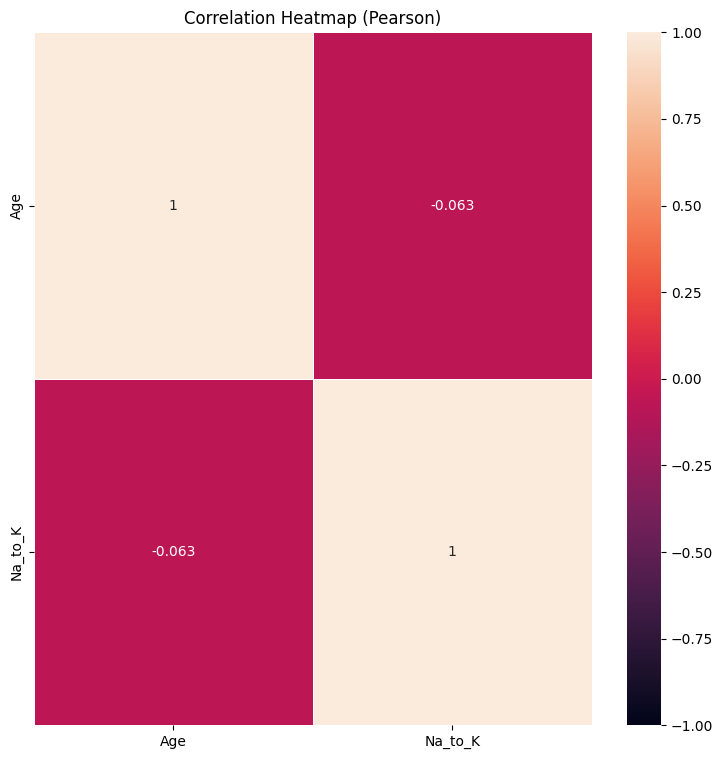

In [ ]:
# Matriz de correlación (Pearson)
correlation_matrix = X.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, vmin=-1, vmax=1, ax=ax)
plt.title("Correlation Heatmap (Pearson)")
plt.show()

Pearson: No se observan correlaciones lineales fuertes entre las variables numéricas.

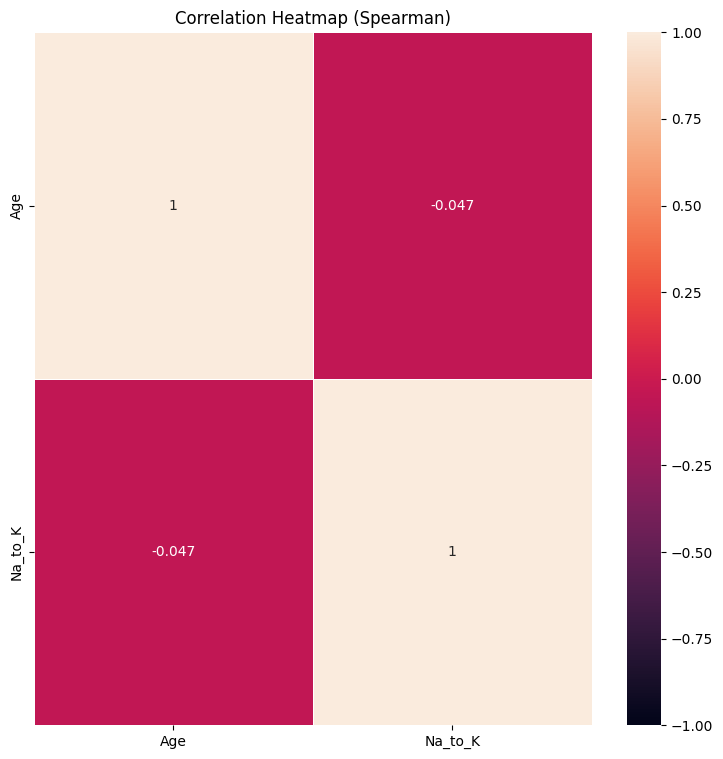

In [ ]:
# Matriz de correlación (Spearman)
correlation_matrix_spearman = X.corr(numeric_only=True, method="spearman")
fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(correlation_matrix_spearman, annot=True, linewidths=.5, vmin=-1, vmax=1, ax=ax)
plt.title("Correlation Heatmap (Spearman)")
plt.show()

Spearman: Se detectan relaciones monótonas, lo que indica que algunas variables pueden influir en la clasificación de medicamentos, aunque no de manera lineal.

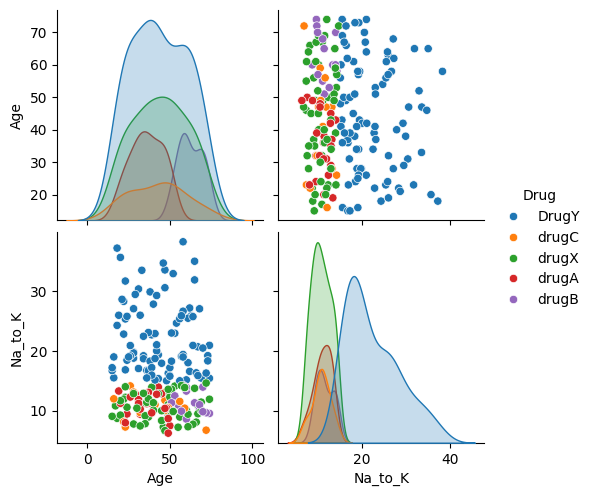

In [ ]:
# Pairplot con variables relevantes y la variable objetivo
sns.pairplot(df, vars=["Age", "Na_to_K"], diag_kind='kde', hue='Drug')
plt.show()

In [ ]:
# Prueba de Kruskal-Wallis para continuas vs categórica
def run_kruskal(df, cont_col, cat_col):
    grouped_data = [group[cont_col] for _, group in df.groupby(cat_col)]
    _, pvalue = kruskal(*grouped_data)
    return pvalue

for i in X.select_dtypes(include="number").columns:
    pvalue = run_kruskal(df, i, "Drug")
    if pvalue < 0.05:
        print(f"La columna {i} es significativa")
    else:
        print(f"No hay diferencias significativas en {i}")

La columna Age es significativa
La columna Na_to_K es significativa


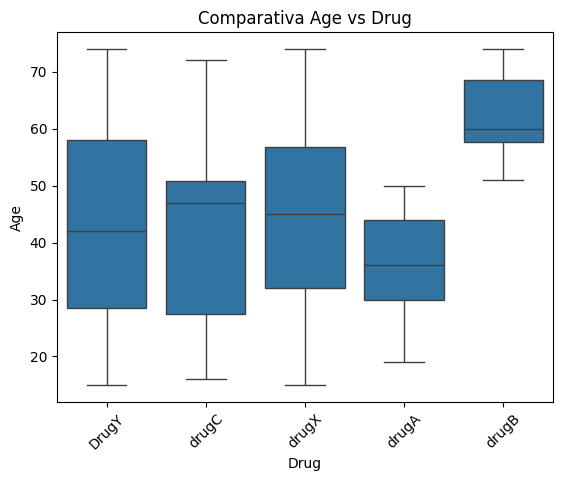

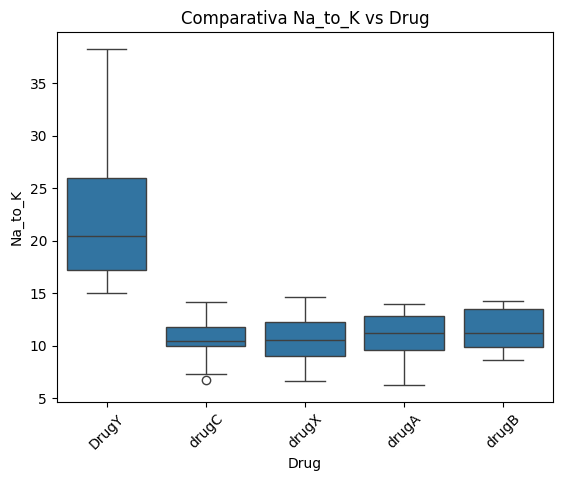

In [ ]:
# Boxplots de variables continuas vs variable categórica
def plot_boxplots(df, numeric_cols, cat_col):
    for col in numeric_cols:
        sns.boxplot(data=df, y=col, x=cat_col)
        plt.title(f"Comparativa {col} vs {cat_col}")
        plt.xticks(rotation=45)
        plt.show()

plot_boxplots(df, ["Age", "Na_to_K"], "Drug")

In [ ]:
# Prueba de Chi-cuadrado para categóricas vs categórica
def chi_square_test(df, cat_col1, cat_col2):
    contingency_table = pd.crosstab(df[cat_col1], df[cat_col2])
    chi2_stat, p, dof, expected = chi2_contingency(contingency_table)
    return p

categorical_vars = ["Sex", "BP", "Cholesterol"]
for var in categorical_vars:
    p_value = chi_square_test(df, var, "Drug")
    print(f"Chi-cuadrado {var} vs Drug: p-value = {p_value:.3f}")
    if p_value < 0.05:
        print(f"{var} tiene una relación significativa con Drug")
    else:
        print(f"No hay relación significativa entre {var} y Drug")

Chi-cuadrado Sex vs Drug: p-value = 0.714
No hay relación significativa entre Sex y Drug
Chi-cuadrado BP vs Drug: p-value = 0.000
BP tiene una relación significativa con Drug
Chi-cuadrado Cholesterol vs Drug: p-value = 0.001
Cholesterol tiene una relación significativa con Drug


In [ ]:
# Prueba post-hoc (Mann-Whitney U) para comparaciones por pares en Na_to_K y Age
import itertools

drugs = df["Drug"].unique()
posthoc_results = {"Age": {}, "Na_to_K": {}}

for d1, d2 in itertools.combinations(drugs, 2):
    stat_age, p_age = mannwhitneyu(df[df["Drug"] == d1]["Age"], df[df["Drug"] == d2]["Age"])
    stat_natok, p_natok = mannwhitneyu(df[df["Drug"] == d1]["Na_to_K"], df[df["Drug"] == d2]["Na_to_K"])
    posthoc_results["Age"][f"{d1} vs {d2}"] = f"U={stat_age:.3f}, p-value={p_age:.3f}"
    posthoc_results["Na_to_K"][f"{d1} vs {d2}"] = f"U={stat_natok:.3f}, p-value={p_natok:.3f}"

print("Resultados post-hoc para Age y Na_to_K vs Drug:")
print(posthoc_results)

Resultados post-hoc para Age y Na_to_K vs Drug:
{'Age': {'DrugY vs drugC': 'U=757.000, p-value=0.803', 'DrugY vs drugX': 'U=2437.000, p-value=0.936', 'DrugY vs drugA': 'U=1322.000, p-value=0.052', 'DrugY vs drugB': 'U=267.500, p-value=0.000', 'drugC vs drugX': 'U=408.000, p-value=0.742', 'drugC vs drugA': 'U=225.000, p-value=0.247', 'drugC vs drugB': 'U=34.000, p-value=0.000', 'drugX vs drugA': 'U=809.000, p-value=0.037', 'drugX vs drugB': 'U=145.500, p-value=0.000', 'drugA vs drugB': 'U=0.000, p-value=0.000'}, 'Na_to_K': {'DrugY vs drugC': 'U=1456.000, p-value=0.000', 'DrugY vs drugX': 'U=4914.000, p-value=0.000', 'DrugY vs drugA': 'U=2093.000, p-value=0.000', 'DrugY vs drugB': 'U=1456.000, p-value=0.000', 'drugC vs drugX': 'U=447.500, p-value=0.834', 'drugC vs drugA': 'U=170.000, p-value=0.700', 'drugC vs drugB': 'U=106.000, p-value=0.418', 'drugX vs drugA': 'U=566.000, p-value=0.544', 'drugX vs drugB': 'U=331.000, p-value=0.160', 'drugA vs drugB': 'U=157.000, p-value=0.449'}}


- Na_to_K es la variable más relevante para la clasificación de medicamentos.
- BP y Cholesterol también influyen en la asignación del fármaco, mientras que Sex no tiene un impacto significativo.
- Los datos no siguen una distribución normal, por lo que se deben emplear métodos no paramétricos.
- Hay presencia de outliers, lo que podría requerir una transformación de datos o análisis más profundo.